<a href="https://colab.research.google.com/github/Mmiglio/SpeechRecognition/blob/audio_features/notebooks/Audio_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/analysisFunctions.py

## Download speech data

In [2]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [3]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835


In [4]:
trainDF.head()

,files,labels,category
0,speechData/train/down/eefd26f3_nohash_0.wav,21,down
1,speechData/train/seven/093f65a1_nohash_0.wav,11,seven
2,speechData/train/right/f216055e_nohash_1.wav,4,right
3,speechData/train/no/e7ea8b76_nohash_2.wav,9,no
4,speechData/train/eight/3dfd6c23_nohash_0.wav,5,eight


## Tensorflow 2.0

In [5]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 63kB/s 
     |████████████████████████████████| 3.1MB 37.3MB/s 
     |████████████████████████████████| 501kB 44.5MB/s 


In [6]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


## Input pipeline

In [7]:
!pip install -q python_speech_features

In [0]:
!pip install -q librosa

In [0]:
from trainingUtils import getDatasetRhythm, getDataset

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 32

train_data, train_steps = getDatasetRhythm(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True
) 

val_data, val_steps = getDatasetRhythm(
    df=valDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False
)

test_data, test_steps = getDatasetRhythm(
    df=testDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False
) 


Librosa vawe:[ 1.1173936e-06 -2.8865807e-05 -1.3148614e-04 -1.7877981e-04
 -7.8574929e-05], sampling rate = 22050
Scipy vawe:[ 0. -2. -6. -2. -2.], sampling rate = 16000
Tempogram shape: (99, 55)
LogMelSpectrogram shape: (99, 40)


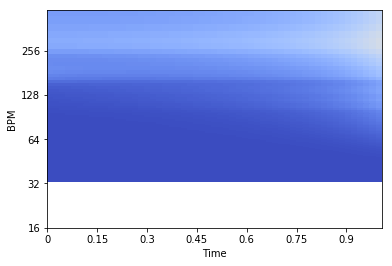

In [10]:
from trainingUtils import _loadLibrosa, _loadWavs, _rhythm, _logMelFilterbank
from librosa.display import specshow


vaweLibrosa, sr = _loadLibrosa(trainDF.files[0])
vaweScipy = _loadWavs(trainDF.files[0])
print('Librosa vawe:{}, sampling rate = {}'.format(vaweLibrosa[:5], sr))
print('Scipy vawe:{}, sampling rate = {}'.format(vaweScipy[:5], len(vaweScipy)))
fbankrhythm = _rhythm(vaweLibrosa, sr, 404)
fbanklogmel = _logMelFilterbank(vaweScipy, 40)
print('Tempogram shape: ({}, {})'.format(len(fbankrhythm), len(fbankrhythm[0])))
print('LogMelSpectrogram shape: ({}, {})'.format(len(fbanklogmel), len(fbanklogmel[0])))

specshow(fbankrhythm, sr=sr, hop_length=404, x_axis='time', y_axis='tempo')

## Model

In [11]:
from models import cnnModel

model = cnnModel()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 99, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 40, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 40, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 99, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 40, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 40, 16)        6

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])

In [13]:
EPOCHS = 40

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("bestCnnModel.h5", monitor='val_loss', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])



W0719 09:44:47.422379 140275119818496 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0719 09:44:47.423475 140275128211200 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0719 09:44:47.427950 140275128211200 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0719 09:44:47.429609 140275128211200 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0719 09:44:47.425287 140275119818496 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32


Epoch 1/40


W0719 09:44:53.134277 140278676703104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/1 [==============================] - 23s 23s/step - loss: 4.5763 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 3.3962 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/40
1/1 [==============================] - 0s 199ms/step - loss: 3.8668 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 3.3903 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/40
1/1 [==============================] - 0s 179ms/step - loss: 4.0036 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 3.3844 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/40
1/1 [==============================] - 0s 192ms/step - loss: 3.8271 - sparse_categorical_accuracy: 0.0312 - val_loss: 3.3771 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/40
1/1 [==============================] - 0s 179ms/step - loss: 3.4401 - sparse_categorical_accuracy: 0.0938 - val_loss: 3.3698 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/40
1/1 [==============================] - 0s 214ms/step - loss: 2.9974 - sparse_ca

## Save model and trainign history  to drive

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [15]:
!mkdir /content/gdrive/My\ Drive/Colab\ Notebooks/audio_features

mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab Notebooks/audio_features’: File exists


In [16]:
GDRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/audio_features/"

## Save model 
model_json = model.to_json()
with open(GDRIVE_PATH + "model.json", "w") as file:
    file.write(model_json)
# serialize weights to HDF5
model.save_weights(GDRIVE_PATH + "model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [17]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


In [0]:
## test load
with open(GDRIVE_PATH + "train_results.pickle", 'rb') as handle:
    hist = pickle.load(handle)

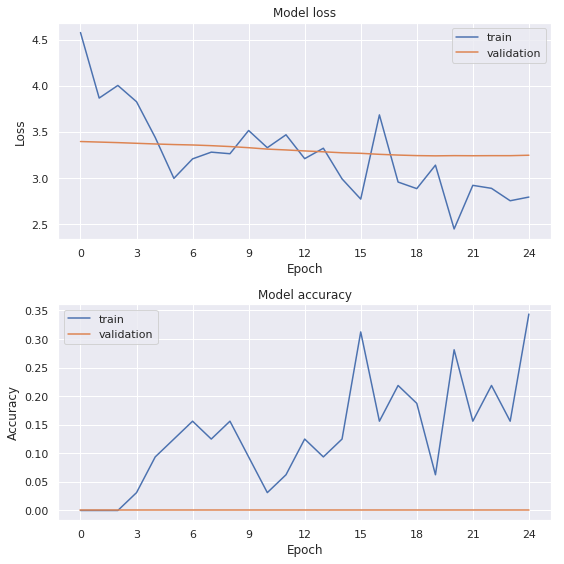

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

acc = hist['sparse_categorical_accuracy']
val_acc = hist['val_sparse_categorical_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

### Predict



In [20]:
out = model.predict(test_data, verbose=1)

1/1 [==============================] - 8s 8s/step


In [0]:
import numpy as np
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist()

In [22]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score,
    f1_score
)

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
print('Precision: {:.4f}'.format(precision_score(y_pred, y_true, average='macro')))
print('Recall: {:.4f}'.format(recall_score(y_pred, y_true, average='macro')))
print('F1 score: {:.4f}'.format(f1_score(y_pred, y_true, average='macro')))
cm = confusion_matrix(y_pred, y_true)

ValueError: ignored

In [0]:
from analysisFunctions import plot_confusion_matrix
from constants import inv_categories
    
plot_confusion_matrix(cm, target_names=list(inv_categories.values())[:-1], normalize=True)